In [99]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from lightgbm import early_stopping, log_evaluation
import warnings
warnings.filterwarnings("ignore",message=r".*A value is trying to be set on a copy of a DataFrame or Series.*",category=FutureWarning)
warnings.filterwarnings("ignore",category=FutureWarning,module=r"sklearn\.metrics\._regression")
# load data
df = pd.read_csv('complete_dataset.csv', parse_dates=['date'])
# sort by date
df.sort_values('date', inplace=True)
# Set the date as an index for easy operation by time
df.set_index('date', inplace=True)

# Print basic information of the dataset
print("data set numbers:", len(df))
print("Column name and data type:")
print(df.dtypes)
print("Start date:", df.index.min(), "End date:", df.index.max())

# Delete unnecessary columns
cols_to_drop = ['demand_pos_RRP', 'RRP_positive', 'demand_neg_RRP', 'RRP_negative', 'frac_at_neg_RRP']
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)
print("Delete column names after removing irrelevant columns:", df.columns.tolist())

data set numbers: 2106
Column name and data type:
demand             float64
RRP                float64
demand_pos_RRP     float64
RRP_positive       float64
demand_neg_RRP     float64
RRP_negative       float64
frac_at_neg_RRP    float64
min_temperature    float64
max_temperature    float64
solar_exposure     float64
rainfall           float64
school_day          object
holiday             object
dtype: object
Start date: 2015-01-01 00:00:00 End date: 2020-10-06 00:00:00
Delete column names after removing irrelevant columns: ['demand', 'RRP', 'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall', 'school_day', 'holiday']


In [61]:
# Check for missing values
missing_counts = df.isna().sum()
print("Number of missing values in each column:")
print(missing_counts[missing_counts > 0])

# Interpolation and filling of missing values related to meteorology
df['solar_exposure'].interpolate(method='linear', inplace=True)
df['rainfall'].interpolate(method='linear', inplace=True)

# If there are still missing values after linear interpolation, use the median to fill in
df['solar_exposure'].fillna(df['solar_exposure'].median(), inplace=True)
df['rainfall'].fillna(df['rainfall'].median(), inplace=True)

# Recheck to confirm that there are no missing values
print("After filling in missing values, the number of missing values in each column is:")
print(df.isna().sum()[df.isna().sum() > 0])

Number of missing values in each column:
solar_exposure    1
rainfall          3
dtype: int64
After filling in missing values, the number of missing values in each column is:
Series([], dtype: int64)


In [63]:
# Construct time lag features: demand for the first 1 day, first 7 days, and first 365 days
df['demand_lag1']   = df['demand'].shift(1)
df['demand_lag7']   = df['demand'].shift(7)
df['demand_lag365'] = df['demand'].shift(365)

# Constructing rolling average features: 7-day and 30-day moving average demand (shift(1) to avoid leakage)
df['demand_roll7']  = df['demand'].rolling(window=7).mean().shift(1)
df['demand_roll30'] = df['demand'].rolling(window=30).mean().shift(1)

# Construct calendar features
df['weekday'] = df.index.weekday  # Monday=0, ..., Sunday=6

# Convert holiday and school day flags to numerical values (1 indicates holiday/school day, 0 indicates no)
df['holiday_flag']     = (df['holiday'] == 'Y').astype(int)
df['school_day_flag']  = (df['school_day'] == 'Y').astype(int)

# Periodic encoding for month
df['sin_month'] = np.sin(2 * np.pi * df.index.month / 12.0)
df['cos_month'] = np.cos(2 * np.pi * df.index.month / 12.0)

# One-hot encode weekday (drop_first to avoid multicollinearity)
weekday_dummies = pd.get_dummies(df['weekday'], prefix='weekday', drop_first=True)
df = pd.concat([df, weekday_dummies], axis=1)

# Delete original fields that are no longer needed
df.drop(columns=['holiday', 'school_day', 'weekday'], inplace=True)

# --- Fill NA created by lag/rolling (avoid chained assignment) ---
lag_features = ['demand_lag1', 'demand_lag7', 'demand_lag365', 'demand_roll7', 'demand_roll30']
# Use per-column median to fill NaNs and assign back in one shot (no chained assignment)
df[lag_features] = df[lag_features].fillna(df[lag_features].median())

# Check result
print("Column of dataset after feature engineering:")
print(df.columns.tolist())
print(df.head(5))

Column of dataset after feature engineering:
['demand', 'RRP', 'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall', 'demand_lag1', 'demand_lag7', 'demand_lag365', 'demand_roll7', 'demand_roll30', 'holiday_flag', 'school_day_flag', 'sin_month', 'cos_month', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']
                demand        RRP  min_temperature  max_temperature  \
date                                                                  
2015-01-01   99635.030  25.633696             13.3             26.9   
2015-01-02  129606.010  33.138988             15.4             38.8   
2015-01-03  142300.540  34.564855             20.0             38.2   
2015-01-04  104330.715  25.005560             16.3             21.4   
2015-01-05  118132.200  26.724176             15.0             22.0   

            solar_exposure  rainfall  demand_lag1  demand_lag7  demand_lag365  \
date                                                                   

In [65]:
# Split the training set (2015-2019) and test set (2020)
train_df = df.loc[:'2019-12-31'].copy()
test_df = df.loc['2020-01-01':].copy()

print("Training set time range:", train_df.index.min(), "to", train_df.index.max(), "Sample size:", len(train_df))
print("Testing set time range:", test_df.index.min(), "to", test_df.index.max(), "Sample size:", len(test_df))

# Separate features and target variables
feature_cols = [
    'RRP', 'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall',
    'holiday_flag', 'school_day_flag',
    'demand_lag1', 'demand_lag7', 'demand_lag365',
    'demand_roll7', 'demand_roll30',
    'sin_month', 'cos_month'
] + [col for col in df.columns if col.startswith('weekday_')]  # Add one-hot code for the day of the week

X_train = train_df[feature_cols].values
y_train = train_df['demand'].values
X_test = test_df[feature_cols].values
y_test = test_df['demand'].values

print("Characteristic dimension: ", X_train.shape[1], "features")

Training set time range: 2015-01-01 00:00:00 to 2019-12-31 00:00:00 Sample size: 1826
Testing set time range: 2020-01-01 00:00:00 to 2020-10-06 00:00:00 Sample size: 280
Characteristic dimension:  20 features


In [79]:
# Seasonal Naïve baseline
# Only take the demand sequence from 2019
y_2019 = df.loc['2019-01-01':'2019-12-31', 'demand'].copy()
# Shift the index overall by 1 year as the 'baseline forecast' for 2020
y_2020_like = y_2019.copy()
y_2020_like.index = y_2020_like.index + pd.DateOffset(years=1)   
# Align with the 2020 test set index to obtain baseline predictions
baseline_pred = y_2020_like.reindex(test_df.index)
# For gaps without corresponding dates from the previous year (such as 2020-02-2
baseline_pred = baseline_pred.ffill().bfill()
# Save as numpy array
y_pred_naive = baseline_pred.values
# Ridge Regression
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0, random_state=42))  # alpha
 ])

# Training and prediction
ridge_pipeline.fit(X_train, y_train)
ridge_pred = ridge_pipeline.predict(X_test)

# LightGBM
lgb_model = LGBMRegressor(
    n_estimators=1200,       # More trees, cooperate with early stop
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=-1            # Turn off redundant outputs
 )

# Simply divide the end of the training as the "validation set" for early stoppi
valid_days = 90
X_tr, y_tr = X_train[:-valid_days], y_train[:-valid_days]
X_val, y_val = X_train[-valid_days:], y_train[-valid_days:]
use_callbacks = True
try:
    callbacks = [
        early_stopping(stopping_rounds=50),  # early stop
        log_evaluation(period=0)             
    ]
    lgb_model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='l1',
        callbacks=callbacks
    )
except Exception as e:
    use_callbacks = False
    print("LightGBM failed to use callbacks")
    lgb_model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='l1',
        early_stopping_rounds=50
    )
# Predicting on the test set using the optimal iteration round
try:
    best_iter = getattr(lgb_model, "best_iteration_", None)
    if best_iter is not None:
        lgb_pred = lgb_model.predict(X_test, num_iteration=best_iter)
    else:
        lgb_pred = lgb_model.predict(X_test)
except Exception:
    lgb_pred = lgb_model.predict(X_test)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[121]	valid_0's l1: 4374.71	valid_0's l2: 3.29059e+07


In [85]:
# Calculate evaluation indicators：MAE、RMSE、MAPE
from math import sqrt

# Prepare actual values and predicted values from various models
y_true = test_df['demand'].values  
y_pred_naive = baseline_pred.values  
y_pred_ridge = ridge_pred 
y_pred_lgb = lgb_pred    

# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# Calculate various indicators
mae_naive = mean_absolute_error(y_true, y_pred_naive)
rmse_naive = mean_squared_error(y_true, y_pred_naive, squared=False)
mape_naive = mean_absolute_percentage_error(y_true, y_pred_naive)

mae_ridge = mean_absolute_error(y_true, y_pred_ridge)
rmse_ridge = mean_squared_error(y_true, y_pred_ridge, squared=False)
mape_ridge = mean_absolute_percentage_error(y_true, y_pred_ridge)

mae_lgb = mean_absolute_error(y_true, y_pred_lgb)
rmse_lgb = mean_squared_error(y_true, y_pred_lgb, squared=False)
mape_lgb = mean_absolute_percentage_error(y_true, y_pred_lgb)

# Print the performance metrics of each model on the test set
print(f"Seasonal Naive baseline model - MAE: {mae_naive:.2f}, RMSE: {rmse_naive:.2f}, MAPE: {mape_naive:.2f}%")
print(f"Ridge regression model - MAE: {mae_ridge:.2f}, RMSE: {rmse_ridge:.2f}, MAPE: {mape_ridge:.2f}%")
print(f"LightGBM model - MAE: {mae_lgb:.2f}, RMSE: {rmse_lgb:.2f}, MAPE: {mape_lgb:.2f}%")

Seasonal Naive baseline model - MAE: 13280.38, RMSE: 17037.58, MAPE: 11.63%
Ridge regression model - MAE: 5087.80, RMSE: 6448.53, MAPE: 4.43%
LightGBM model - MAE: 4077.11, RMSE: 5021.15, MAPE: 3.57%


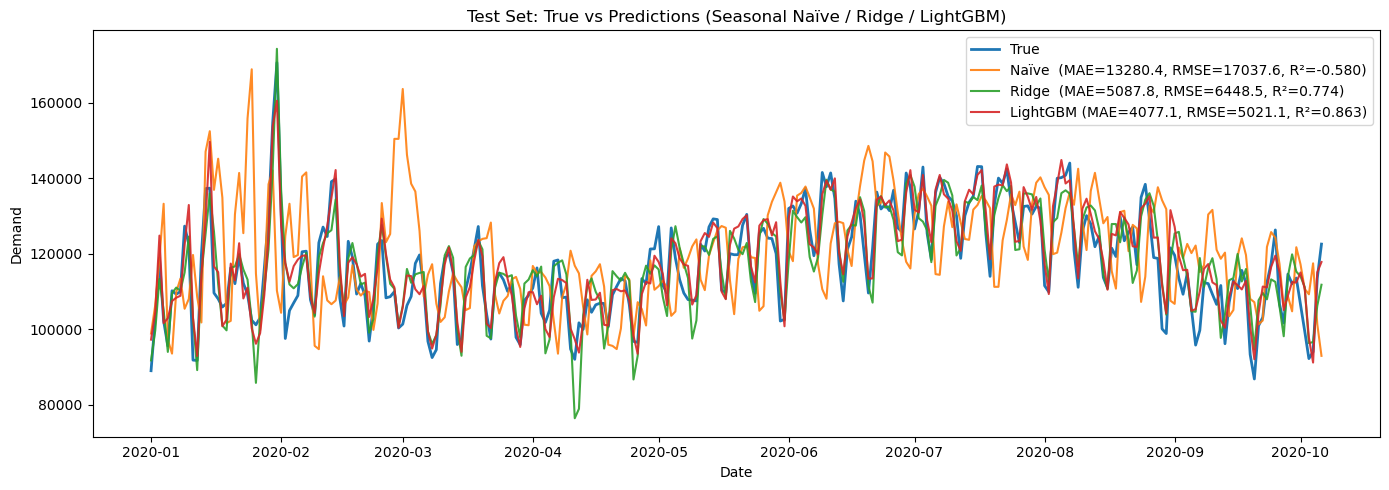

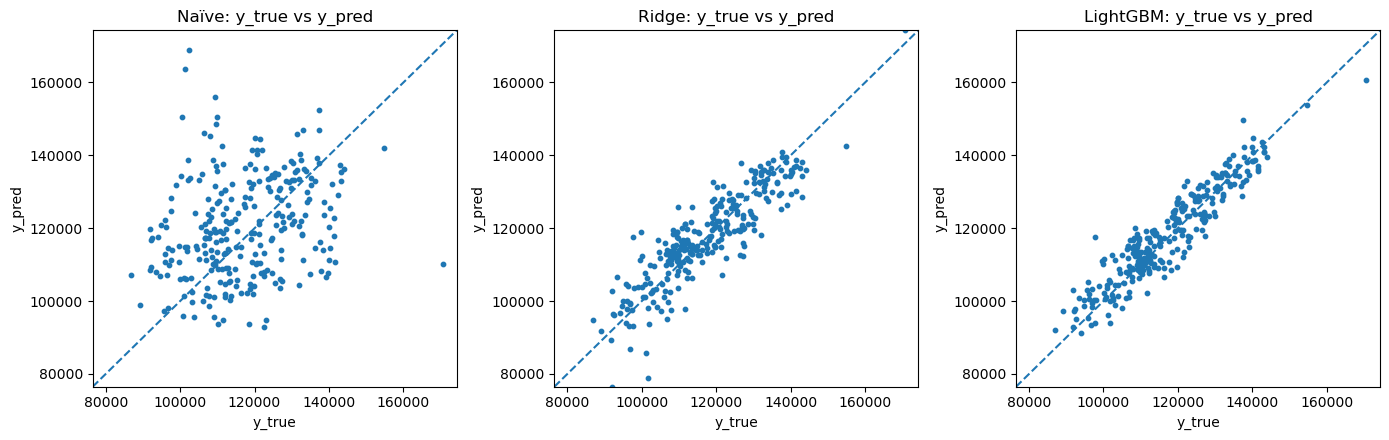

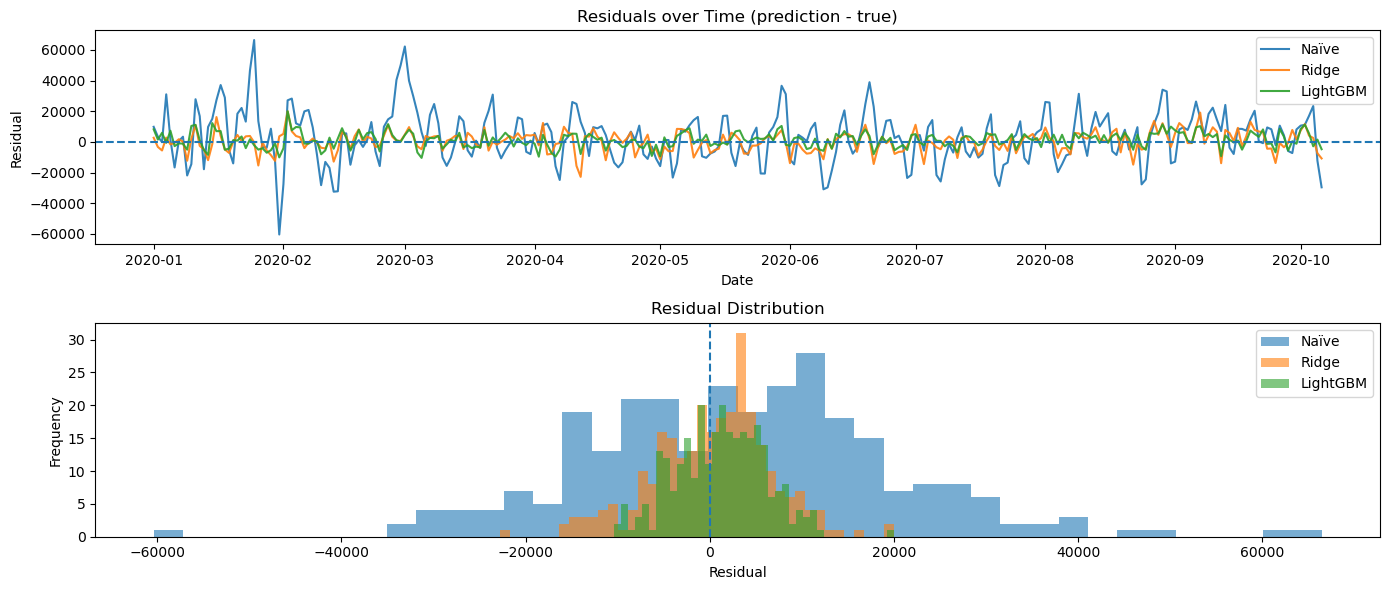

In [93]:
# Visualization: Prediction Comparison and Residual Analysis
# Prepare comparison DataFrame: true values vs predictions from 3 models
viz_df = pd.DataFrame({
    'y_true': y_test,       # ground truth
    'naive':  y_pred_naive, # seasonal naïve baseline
    'ridge':  ridge_pred,   # Ridge regression
    'lgbm':   lgb_pred      # LightGBM
}, index=test_df.index)

# Define function to compute metrics
def _metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Calculate metrics for each model
m_naive = _metrics(viz_df['y_true'], viz_df['naive'])
m_ridge = _metrics(viz_df['y_true'], viz_df['ridge'])
m_lgbm  = _metrics(viz_df['y_true'], viz_df['lgbm'])

# Plot 1: Time series overlay (true vs predictions)
plt.figure(figsize=(14, 5))
plt.plot(viz_df.index, viz_df['y_true'], label='True', linewidth=2)
plt.plot(viz_df.index, viz_df['naive'], label=f'Naïve  (MAE={m_naive[0]:.1f}, RMSE={m_naive[1]:.1f}, R²={m_naive[2]:.3f})', alpha=0.9)
plt.plot(viz_df.index, viz_df['ridge'], label=f'Ridge  (MAE={m_ridge[0]:.1f}, RMSE={m_ridge[1]:.1f}, R²={m_ridge[2]:.3f})', alpha=0.9)
plt.plot(viz_df.index, viz_df['lgbm'],  label=f'LightGBM (MAE={m_lgbm[0]:.1f}, RMSE={m_lgbm[1]:.1f}, R²={m_lgbm[2]:.3f})', alpha=0.9)
plt.title('Test Set: True vs Predictions (Seasonal Naïve / Ridge / LightGBM)')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Scatter plots (y_true vs y_pred for each model)
fig = plt.figure(figsize=(14, 4.5))

ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(viz_df['y_true'], viz_df['naive'], s=10)
lims = [min(viz_df['y_true'].min(), viz_df[['naive','ridge','lgbm']].min().min()),
        max(viz_df['y_true'].max(), viz_df[['naive','ridge','lgbm']].max().max())]
ax1.plot(lims, lims, linestyle='--')
ax1.set_title('Naïve: y_true vs y_pred')
ax1.set_xlabel('y_true'); ax1.set_ylabel('y_pred')

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(viz_df['y_true'], viz_df['ridge'], s=10)
ax2.plot(lims, lims, linestyle='--')
ax2.set_title('Ridge: y_true vs y_pred')
ax2.set_xlabel('y_true'); ax2.set_ylabel('y_pred')

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(viz_df['y_true'], viz_df['lgbm'], s=10)
ax3.plot(lims, lims, linestyle='--')
ax3.set_title('LightGBM: y_true vs y_pred')
ax3.set_xlabel('y_true'); ax3.set_ylabel('y_pred')

for ax in (ax1, ax2, ax3):
    ax.set_xlim(lims); ax.set_ylim(lims)

plt.tight_layout()
plt.show()

# Plot 3: Residual analysis (time series + histogram)
fig = plt.figure(figsize=(14, 6))

# Residuals over time
ax4 = fig.add_subplot(2, 1, 1)
ax4.plot(viz_df.index, viz_df['naive'] - viz_df['y_true'], label='Naïve', alpha=0.9)
ax4.plot(viz_df.index, viz_df['ridge'] - viz_df['y_true'], label='Ridge', alpha=0.9)
ax4.plot(viz_df.index, viz_df['lgbm']  - viz_df['y_true'], label='LightGBM', alpha=0.9)
ax4.axhline(0, linestyle='--')
ax4.set_title('Residuals over Time (prediction - true)')
ax4.set_xlabel('Date'); ax4.set_ylabel('Residual')
ax4.legend()

# Residual distribution
ax5 = fig.add_subplot(2, 1, 2)
ax5.hist(viz_df['naive'] - viz_df['y_true'], bins=40, alpha=0.6, label='Naïve')
ax5.hist(viz_df['ridge'] - viz_df['y_true'], bins=40, alpha=0.6, label='Ridge')
ax5.hist(viz_df['lgbm']  - viz_df['y_true'], bins=40, alpha=0.6, label='LightGBM')
ax5.axvline(0, linestyle='--')
ax5.set_title('Residual Distribution')
ax5.set_xlabel('Residual'); ax5.set_ylabel('Frequency')
ax5.legend()

plt.tight_layout()
plt.show()

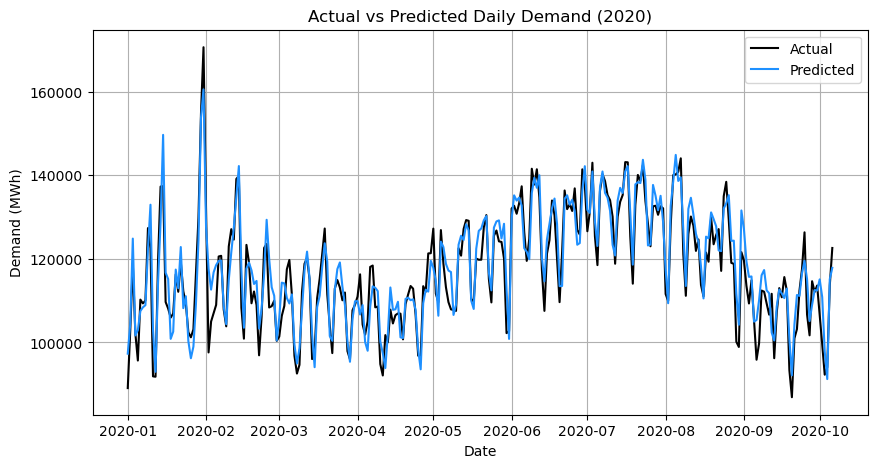

In [95]:
# Time series chart: Comparison of actual demand and model predictions in 2020
plt.figure(figsize=(10,5))
plt.plot(test_df.index, test_df['demand'], label='Actual', color='black')
plt.plot(test_df.index, lgb_pred, label='Predicted', color='dodgerblue')
plt.title("Actual vs Predicted Daily Demand (2020)")
plt.xlabel("Date")
plt.ylabel("Demand (MWh)")
plt.legend()
plt.grid(True)
plt.show()

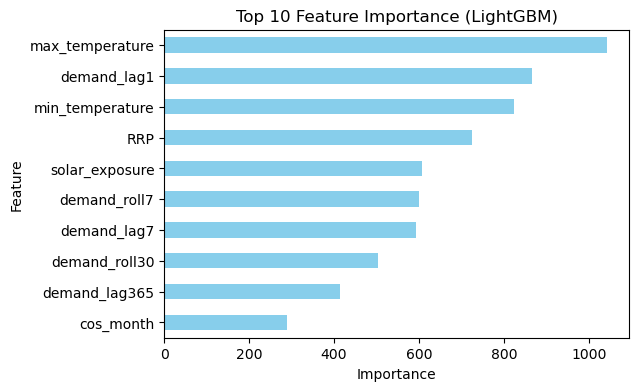

In [97]:
# Feature Importance Map: Feature Importance of LightGBM Model（top 10）
importance_values = lgb_model.feature_importances_
feature_names = feature_cols  
# Convert feature importance to Series and select the top 10
feat_imp_series = pd.Series(importance_values, index=feature_names).sort_values(ascending=False).head(10)
plt.figure(figsize=(6,4))
feat_imp_series.plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis() 
plt.title("Top 10 Feature Importance (LightGBM)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

Victoria – Annual PV installations (2015–2020):
Year
2015    31382
2016    26757
2017    31386
2018    47244
2019    61784
2020    74341
Name: Installations, dtype: int64

Growth from 2015 to 2020: 136.9%


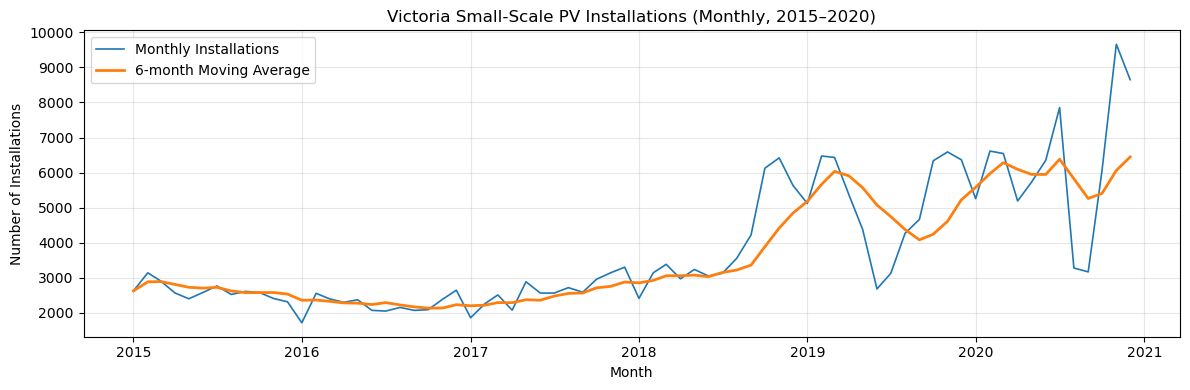

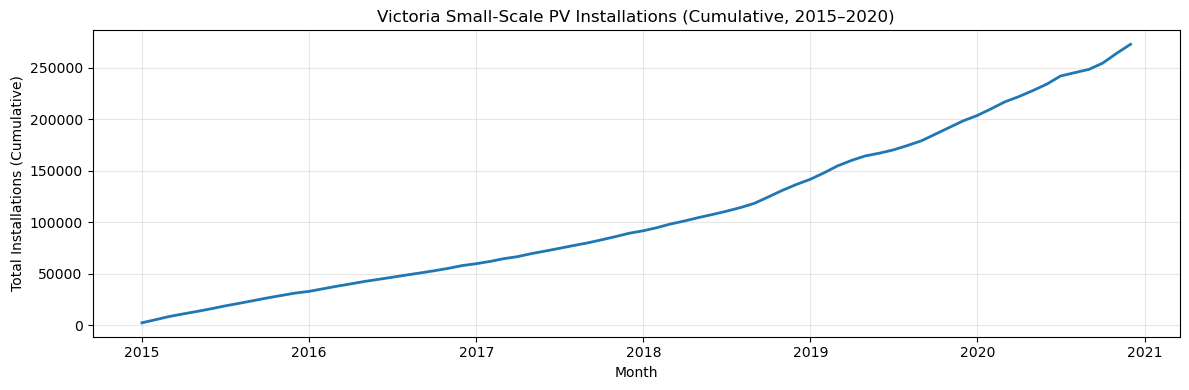

In [101]:
# Read and convert to a long table
csv_file = 'sgu-solar-installations-2011-to-present.csv'  
df_raw = pd.read_csv(csv_file)

# Original Table
df_long = df_raw.melt(
    id_vars=['Small Unit Installation Postcode'],
    var_name='Month',
    value_name='Installations'
)

# Extract month string and convert to date
df_long['MonthStr'] = df_long['Month'].str.extract(r'([A-Za-z]{3}\s+\d{4})', expand=False)
df_long['Date'] = pd.to_datetime(df_long['MonthStr'], format='%b %Y', errors='coerce')

# Convert postal code to integer
df_long['Postcode'] = (
    df_long['Small Unit Installation Postcode']
    .astype(str)
    .str.extract(r'(\d{3,4})', expand=False)
    .astype(float)
    .astype('Int64')
)

# Convert installation quantity to numerical value
df_long['Installations'] = pd.to_numeric(df_long['Installations'], errors='coerce').fillna(0)

# Victoria screening (postal code ranges 3000-3999 and 8000-8999)
vic_mask = (
    (df_long['Postcode'].between(3000, 3999)) |
    (df_long['Postcode'].between(8000, 8999))
)
df_vic = df_long.loc[vic_mask, ['Date', 'Installations']].dropna(subset=['Date'])

# Take 2015-2020 and conduct monthly aggregation
df_vic_2015_2020 = df_vic[(df_vic['Date'] >= '2015-01-01') & (df_vic['Date'] <= '2020-12-31')]
monthly_vic = (
    df_vic_2015_2020
    .groupby('Date', as_index=False)['Installations']
    .sum()
    .sort_values('Date')
)
# 6-month rolling average
monthly_vic['MA6'] = monthly_vic['Installations'].rolling(6, min_periods=1).mean()

# Simple annual total and growth rate
annual_vic = (
    monthly_vic.assign(Year=lambda d: d['Date'].dt.year)
               .groupby('Year', as_index=True)['Installations']
               .sum()
)
print("Victoria – Annual PV installations (2015–2020):")
print(annual_vic)

# Measuring overall growth by annual total (2015 → 2020)
if 2015 in annual_vic.index and 2020 in annual_vic.index and annual_vic.loc[2015] > 0:
    growth_pct = (annual_vic.loc[2020] / annual_vic.loc[2015] - 1) * 100
    print(f"\nGrowth from 2015 to 2020: {growth_pct:.1f}%")
else:
    print("\nNote: 2015 or 2020 annual total missing/zero; growth rate not computed.")

# Trend visualization
plt.figure(figsize=(12, 4))
plt.plot(monthly_vic['Date'], monthly_vic['Installations'], label='Monthly Installations', linewidth=1.2)
plt.plot(monthly_vic['Date'], monthly_vic['MA6'], label='6-month Moving Average', linewidth=2.0)
plt.title('Victoria Small-Scale PV Installations (Monthly, 2015–2020)')
plt.xlabel('Month')
plt.ylabel('Number of Installations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cumulative curve
monthly_vic['Cumulative'] = monthly_vic['Installations'].cumsum()
plt.figure(figsize=(12, 4))
plt.plot(monthly_vic['Date'], monthly_vic['Cumulative'], linewidth=2.0)
plt.title('Victoria Small-Scale PV Installations (Cumulative, 2015–2020)')
plt.xlabel('Month')
plt.ylabel('Total Installations (Cumulative)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()